Importing Libraries

In [1]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch import Tensor
from typing import Optional
from typing import Tuple
import torch.nn.init as init


In [2]:
import librosa
import os
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np

Mounting drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Accesing GPU

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Loading dataset

In [5]:
csv_file_path='/content/drive/MyDrive/archive (24)/TRAIN.csv'
folder_path_train='/content/drive/MyDrive/archive (24)/TRAIN'


In [6]:
df=pd.read_csv('/content/drive/MyDrive/archive (24)/TRAIN.csv')

In [7]:
df

,Filename,Class
0,346.wav,Negative
1,163.wav,Neutral
2,288.wav,Negative
3,279.wav,Negative
4,244.wav,Negative
...,...,...
245,204.wav,Neutral
246,46.wav,Positive
247,318.wav,Negative
248,49.wav,Positive


Splitting dataset

In [8]:
#split df into train,test,validation
from sklearn.model_selection import train_test_split
train_df,temp=train_test_split(df,test_size=0.3,random_state=28)
test_df,valid_df=train_test_split(temp,test_size=0.6,random_state=28)

In [9]:
train_df.shape

(175, 2)

In [10]:
valid_df.shape

(45, 2)

In [11]:
test_df.shape

(30, 2)

Class for loading audio files

In [12]:
class AudioDataset(torch.utils.data.Dataset):
  def __init__(self, folder_path, target_sample_rate,csv_file, resize_dim=(15,800)):
    self.csv_file = csv_file
    self.folder_path = folder_path
    self.sample_rate = target_sample_rate
    self.resize_dim =  resize_dim
    self.mapping = {"Positive": [1, 0, 0], "Neutral": [0, 1, 0], "Negative": [0, 0, 1]}

  def __getitem__(self, idx):
    filename = os.path.join(self.folder_path, self.csv_file.iloc[idx, 0])
    audio_data, sr = librosa.load(filename, sr=self.sample_rate)
    audio_data = librosa.feature.melspectrogram(y=audio_data,sr=target_sample_rate,n_fft=400,hop_length=160,n_mels=15)
    audio_data = cv2.resize(audio_data, self.resize_dim)
    audio_data=audio_data.reshape(1,800,15)
    labels = self.csv_file.iloc[idx, 1]
    labels = np.array(self.mapping[labels])

    return audio_data,  labels

  def __len__(self):
    return len(self.csv_file)


In [13]:
target_sample_rate=44100

In [14]:
train_data=AudioDataset(folder_path_train,44100,train_df)
valid_data=AudioDataset(folder_path_train,44100,valid_df)
test_data=AudioDataset(folder_path_train,44100,test_df)

In [15]:
print(len(train_data))

175


In [16]:
print(len(test_data))

30


In [17]:
train_data[65][0].shape

(1, 800, 15)

creating batches using dataloader

In [18]:
from torch.utils.data import  DataLoader
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=8,shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=8,shuffle=True, drop_last=True)

In [19]:
len(train_dataloader)

21

In [20]:
len(valid_dataloader)

5

In [21]:
len(test_dataloader)

3

In [22]:
for audios,labels in train_dataloader:
  print(audios.shape, labels.shape)
  break

torch.Size([8, 1, 800, 15]) torch.Size([8, 3])


Positional embedding

In [23]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding proposed in "Attention Is All You Need".
    Since transformer contains no recurrence and no convolution, in order for the model to make
    use of the order of the sequence, we must add some positional information.

    "Attention Is All You Need" use sine and cosine functions of different frequencies:
        PE_(pos, 2i)    =  sin(pos / power(10000, 2i / d_model))
        PE_(pos, 2i+1)  =  cos(pos / power(10000, 2i / d_model))
    """
    def __init__(self, d_model: int = 512, max_len: int = 800) -> None:
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model, requires_grad=False)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, length: int) -> torch.Tensor:
        result = self.pe[:, :length]
        #print("pos_encoding output",result.shape)
        return result

Activation function

In [24]:
class Swish(nn.Module):
    """
    Swish is a smooth, non-monotonic function that consistently matches or outperforms ReLU on deep networks applied
    to a variety of challenging domains such as Image classification and Machine translation.
    """
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, inputs: Tensor) -> Tensor:
        result= inputs * inputs.sigmoid()
        #print("swish output",result.shape)  # Print the result
        return result


class GLU(nn.Module):
    """
    The gating mechanism is called Gated Linear Units (GLU), which was first introduced for natural language processing
    in the paper “Language Modeling with Gated Convolutional Networks”
    """

    def __init__(self, dim: int) -> None:
        super(GLU, self).__init__()
        self.dim = dim

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:

        outputs, gate = inputs.chunk(2, dim=self.dim)
        result = outputs * gate.sigmoid()
        #print('GLU output',result.shape)  # Print the result
        return result

#modules

In [25]:
class ResidualConnectionModule(nn.Module):
    """
    Residual Connection Module.
    outputs = (module(inputs) x module_factor + inputs x input_factor)
    """
    def __init__(self, module: nn.Module, module_factor: float = 1.0, input_factor: float = 1.0):
        super(ResidualConnectionModule, self).__init__()
        self.module = module
        self.module_factor = module_factor
        self.input_factor = input_factor

    def forward(self, inputs: Tensor) -> Tensor:
        return (self.module(inputs) * self.module_factor) + (inputs * self.input_factor)


class Linear(nn.Module):
    """
    Wrapper class of torch.nn.Linear
    Weight initialize by xavier initialization and bias initialize to zeros.
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True) -> None:
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        init.xavier_uniform_(self.linear.weight)
        if bias:
            init.zeros_(self.linear.bias)

    def forward(self, x: Tensor) -> Tensor:
        return self.linear(x)


class View(nn.Module):
    """ Wrapper class of torch.view() for Sequential module. """
    def __init__(self, shape: tuple, contiguous: bool = False):
        super(View, self).__init__()
        self.shape = shape
        self.contiguous = contiguous

    def forward(self, x: Tensor) -> Tensor:
        if self.contiguous:
            x = x.contiguous()

        return x.view(*self.shape)


class Transpose(nn.Module):
    """ Wrapper class of torch.transpose() for Sequential module. """
    def __init__(self, shape: tuple):
        super(Transpose, self).__init__()
        self.shape = shape

    def forward(self, x: Tensor) -> Tensor:
        return x.transpose(*self.shape)

#Attention module

In [26]:
class RelativeMultiHeadAttention(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    This concept was proposed in the "Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context"

    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout

    Inputs: query, key, value, pos_embedding, mask
        - **query** (batch, time, dim): Tensor containing query vector
        - **key** (batch, time, dim): Tensor containing key vector
        - **value** (batch, time, dim): Tensor containing value vector
        - **pos_embedding** (batch, time, dim): Positional embedding tensor
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked

    Returns:
        - **outputs**: Tensor produces by relative multi head attention module.
    """
    def __init__(
            self,
            d_model: int = 512,
            num_heads: int = 16,
            dropout_p: float = 0.1,
    ):
        super(RelativeMultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model % num_heads should be zero."
        self.d_model = d_model
        self.d_head = int(d_model / num_heads)
        self.num_heads = num_heads
        self.sqrt_dim = math.sqrt(d_model)

        self.query_proj = Linear(d_model, d_model)
        self.key_proj = Linear(d_model, d_model)
        self.value_proj = Linear(d_model, d_model)
        self.pos_proj = Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(p=dropout_p)
        self.u_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        self.v_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        torch.nn.init.xavier_uniform_(self.u_bias)
        torch.nn.init.xavier_uniform_(self.v_bias)

        self.out_proj = Linear(d_model, d_model)

    def forward(
            self,
            query: Tensor,
            key: Tensor,
            value: Tensor,
            pos_embedding: Tensor,
            mask: Optional[Tensor] = None,
    ) -> Tensor:
        batch_size = value.size(0)

        query = self.query_proj(query).view(batch_size, -1, self.num_heads, self.d_head)
        key = self.key_proj(key).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value_proj(value).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        pos_embedding = self.pos_proj(pos_embedding).view(batch_size, -1, self.num_heads, self.d_head)

        content_score = torch.matmul((query + self.u_bias).transpose(1, 2), key.transpose(2, 3))
        pos_score = torch.matmul((query + self.v_bias).transpose(1, 2), pos_embedding.permute(0, 2, 3, 1))
        pos_score = self._relative_shift(pos_score)

        score = (content_score + pos_score) / self.sqrt_dim

        if mask is not None:
            mask = mask.unsqueeze(1)
            score.masked_fill_(mask, -1e9)

        attn = F.softmax(score, -1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, value).transpose(1, 2)
        context = context.contiguous().view(batch_size, -1, self.d_model)

        return self.out_proj(context)

    def _relative_shift(self, pos_score: Tensor) -> Tensor:
        batch_size, num_heads, seq_length1, seq_length2 = pos_score.size()
        zeros = pos_score.new_zeros(batch_size, num_heads, seq_length1, 1)
        padded_pos_score = torch.cat([zeros, pos_score], dim=-1)

        padded_pos_score = padded_pos_score.view(batch_size, num_heads, seq_length2 + 1, seq_length1)
        pos_score = padded_pos_score[:, :, 1:].view_as(pos_score)

        return pos_score


class MultiHeadedSelfAttentionModule(nn.Module):
    """
    Conformer employ multi-headed self-attention (MHSA) while integrating an important technique from Transformer-XL,
    the relative sinusoidal positional encoding scheme. The relative positional encoding allows the self-attention
    module to generalize better on different input length and the resulting encoder is more robust to the variance of
    the utterance length. Conformer use prenorm residual units with dropout which helps training
    and regularizing deeper models.

    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout

    Inputs: inputs, mask
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked

    Returns:
        - **outputs** (batch, time, dim): Tensor produces by relative multi headed self attention module.
    """
    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.1):
        super(MultiHeadedSelfAttentionModule, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.attention = RelativeMultiHeadAttention(d_model, num_heads, dropout_p)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, inputs: Tensor, mask: Optional[Tensor] = None):
        batch_size, seq_length, _ = inputs.size()
        pos_embedding = self.positional_encoding(seq_length)
        pos_embedding = pos_embedding.repeat(batch_size, 1, 1)

        inputs = self.layer_norm(inputs)
        outputs = self.attention(inputs, inputs, inputs, pos_embedding=pos_embedding, mask=mask)

        # Print the results within the function
        #print("attention Input Shape:", inputs.shape)
        #print("attention Output Shape:", outputs.shape)

        return self.dropout(outputs)

#convolution module

In [27]:
class DepthwiseConv1d(nn.Module):
    """
    When groups == in_channels and out_channels == K * in_channels, where K is a positive integer,
    this operation is termed in literature as depthwise convolution.

    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True

    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector

    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by depthwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = False,
    ) -> None:
        super(DepthwiseConv1d, self).__init__()
        assert out_channels % in_channels == 0, "out_channels should be constant multiple of in_channels"
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        outputs = self.conv(inputs)
        #print("Convolution Output Shape:", outputs.shape)
        return outputs


class PointwiseConv1d(nn.Module):
    """
    When kernel size == 1 conv1d, this operation is termed in literature as pointwise convolution.
    This operation often used to match dimensions.

    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True

    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector

    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by pointwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = True,
    ) -> None:
        super(PointwiseConv1d, self).__init__()
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        outputs = self.conv(inputs)
        #print("Pointwise Convolution Output Shape:", outputs.shape)
        return outputs


class ConformerConvModule(nn.Module):
    """
    Conformer convolution module starts with a pointwise convolution and a gated linear unit (GLU).
    This is followed by a single 1-D depthwise convolution layer. Batchnorm is  deployed just after the convolution
    to aid training deep models.

    Args:
        in_channels (int): Number of channels in the input
        kernel_size (int or tuple, optional): Size of the convolving kernel Default: 31
        dropout_p (float, optional): probability of dropout

    Inputs: inputs
        inputs (batch, time, dim): Tensor contains input sequences

    Outputs: outputs
        outputs (batch, time, dim): Tensor produces by conformer convolution module.
    """
    def __init__(
            self,
            in_channels: int,
            kernel_size: int = 31,
            expansion_factor: int = 2,
            dropout_p: float = 0.1,
    ) -> None:
        super(ConformerConvModule, self).__init__()
        assert (kernel_size - 1) % 2 == 0, "kernel_size should be a odd number for 'SAME' padding"
        assert expansion_factor == 2, "Currently, Only Supports expansion_factor 2"

        self.sequential = nn.Sequential(
            nn.LayerNorm(in_channels),
            Transpose(shape=(1, 2)),
            PointwiseConv1d(in_channels, in_channels * expansion_factor, stride=1, padding=0, bias=True),
            GLU(dim=1),
            DepthwiseConv1d(in_channels, in_channels, kernel_size, stride=1, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(in_channels),
            Swish(),
            PointwiseConv1d(in_channels, in_channels, stride=1, padding=0, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
            output = self.sequential(inputs).transpose(1, 2)
            # Print the shape of the output tensor
            #print(" conformer convolutional modelOutput Shape:", output.shape)

            return output


class Conv2dSubampling(nn.Module):
    """
    Convolutional 2D subsampling (to 1/4 length)

    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs

    Returns: outputs, output_lengths
        - **outputs** (batch, time, dim): Tensor produced by the convolution
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(Conv2dSubampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
        )

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
       # print("Conv2dSubsampling Input Shape:", inputs.shape)  # Print the input shape
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, sumsampled_dim = outputs.size()

        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * sumsampled_dim)

        output_lengths = input_lengths >> 2
        output_lengths -= 1

        # Print the output shape
        #print("Conv2dSubampling Output Shape:", outputs.shape)
        return outputs, output_lengths

#Feed forward layer

In [28]:
class FeedForwardModule(nn.Module):
    """
    Conformer Feed Forward Module follow pre-norm residual units and apply layer normalization within the residual unit
    and on the input before the first linear layer. This module also apply Swish activation and dropout, which helps
    regularizing the network.

    Args:
        encoder_dim (int): Dimension of conformer encoder
        expansion_factor (int): Expansion factor of feed forward module.
        dropout_p (float): Ratio of dropout

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor contains input sequences

    Outputs: outputs
        - **outputs** (batch, time, dim): Tensor produces by feed forward module.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            expansion_factor: int = 4,
            dropout_p: float = 0.1,
    ) -> None:
        super(FeedForwardModule, self).__init__()
        self.sequential = nn.Sequential(
            nn.LayerNorm(encoder_dim),
            Linear(encoder_dim, encoder_dim * expansion_factor, bias=True),
            Swish(),
            nn.Dropout(p=dropout_p),
            Linear(encoder_dim * expansion_factor, encoder_dim, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        outputs = self.sequential(inputs)

        # Print the output shape
        #print("feed forward Output Shape:", outputs.shape)

        return outputs

In [29]:
class ConformerBlock(nn.Module):
    """
    Conformer block contains two Feed Forward modules sandwiching the Multi-Headed Self-Attention module
    and the Convolution module. This sandwich structure is inspired by Macaron-Net, which proposes replacing
    the original feed-forward layer in the Transformer block into two half-step feed-forward layers,
    one before the attention layer and one after.

    Args:
        encoder_dim (int, optional): Dimension of conformer encoder
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector

    Returns: outputs
        - **outputs** (batch, time, dim): Tensor produces by conformer block.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerBlock, self).__init__()
        if half_step_residual:
            self.feed_forward_residual_factor = 0.5
        else:
            self.feed_forward_residual_factor = 1

        self.sequential = nn.Sequential(
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            ResidualConnectionModule(
                module=MultiHeadedSelfAttentionModule(
                    d_model=encoder_dim,
                    num_heads=num_attention_heads,
                    dropout_p=attention_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=ConformerConvModule(
                    in_channels=encoder_dim,
                    kernel_size=conv_kernel_size,
                    expansion_factor=conv_expansion_factor,
                    dropout_p=conv_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            nn.LayerNorm(encoder_dim),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        outputs = self.sequential(inputs)

        # Print the output shape
        #print("Conformer Block Output Shape:", outputs.shape)

        return outputs

class ConformerEncoder(nn.Module):
    """
    Conformer encoder first processes the input with a convolution subsampling layer and then
    with a number of conformer blocks.

    Args:
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not

    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths

    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer encoder.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            input_dim: int = 80,
            encoder_dim: int = 512,
            num_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerEncoder, self).__init__()
        self.conv_subsample = Conv2dSubampling(in_channels=1, out_channels=encoder_dim)
        self.input_projection = nn.Sequential(
            Linear(encoder_dim * (((input_dim - 1) // 2 - 1) // 2), encoder_dim),
            nn.Dropout(p=input_dropout_p),
        )
        self.layers = nn.ModuleList([ConformerBlock(
            encoder_dim=encoder_dim,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        ) for _ in range(num_layers)])

    ''' def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return sum([p.numel() for p in self.parameters()])

    def update_dropout(self, dropout_p: float) -> None:
        """ Update dropout probability of encoder """
        for name, child in self.named_children():
            if isinstance(child, nn.Dropout):
                child.p = dropout_p'''

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` for  encoder training.

        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``

        Returns:
            (Tensor, Tensor)

            * outputs (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
            * output_lengths (torch.LongTensor): The length of output tensor. ``(batch)``
        """

        outputs, output_lengths = self.conv_subsample(inputs, input_lengths)
        outputs = self.input_projection(outputs)

        for layer in self.layers:
            outputs = layer(outputs)
            # Print the output shape
            #print(" conformer encoder Output Shape:", outputs.shape)
            return outputs, output_lengths

In [30]:
class Conformer(nn.Module):
    """
    Conformer: Convolution-augmented Transformer for Speech Recognition
    The paper used a one-lstm Transducer decoder, currently still only implemented
    the conformer encoder shown in the paper.

    Args:
        num_classes (int): Number of classification classes
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_encoder_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not

    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths

    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            num_classes: int,
            input_dim: int = 80,
            encoder_dim: int = 512,
            num_encoder_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ) -> None:
        super(Conformer, self).__init__()
        self.encoder = ConformerEncoder(
            input_dim=input_dim,
            encoder_dim=encoder_dim,
            num_layers=num_encoder_layers,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            input_dropout_p=input_dropout_p,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        )
        self.fc = Linear(encoder_dim, num_classes, bias=False)

    '''def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return self.encoder.count_parameters()

    def update_dropout(self, dropout_p) -> None:
        """ Update dropout probability of model """
        self.encoder.update_dropout(dropout_p)'''

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` and `targets` pair for training.

        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``

        Returns:
            * predictions (torch.FloatTensor): Result of model predictions.
        """
        encoder_outputs, encoder_output_lengths = self.encoder(inputs, input_lengths)
        outputs = self.fc(encoder_outputs)
        outputs = nn.functional.softmax(outputs, dim=-1)
        #print(" conformer Output Shape:", outputs.shape)

        return outputs, encoder_output_lengths

Architexture of conformer model:

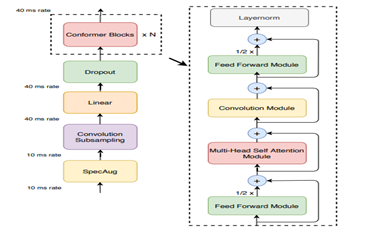

In [31]:
# Define the model hyperparameters
num_classes = 3
input_dim = 15
encoder_dim = 800
num_encoder_layers = 17
num_attention_heads = 8
feed_forward_expansion_factor = 4
conv_expansion_factor = 2
input_dropout_p = 0.1
feed_forward_dropout_p = 0.1
attention_dropout_p = 0.1
conv_dropout_p = 0.1
conv_kernel_size = 31
half_step_residual = True

# Initialize the Conformer model
model = Conformer(
    num_classes=num_classes,
    input_dim=input_dim,
    encoder_dim=encoder_dim,
    num_encoder_layers=num_encoder_layers,
    num_attention_heads=num_attention_heads,
    feed_forward_expansion_factor=feed_forward_expansion_factor,
    conv_expansion_factor=conv_expansion_factor,
    input_dropout_p=input_dropout_p,
    feed_forward_dropout_p=feed_forward_dropout_p,
    attention_dropout_p=attention_dropout_p,
    conv_dropout_p=conv_dropout_p,
    conv_kernel_size=conv_kernel_size,
    half_step_residual=half_step_residual
)

In [32]:
model=model.to(device)# moving model to GPU

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [34]:
num_epochs=75

Training and validation

In [35]:
from tqdm import tqdm
train_losses = []  # To store training losses for each epoch
valid_losses = []  # To store validation losses for each epoch

for epoch in tqdm(range(num_epochs)):
      model.train()  # Set the model to training mode
      total_train_loss = 0.0

      for audios, labels in train_dataloader:
            audios = audios.to(device)
            labels = labels.to(device)
            #print(audios.shape)

            audios = audios.permute(0, 2, 1, 3)

          # Reshape to match the expected input shape
            audios = audios.view(8, 800, 15)
            input_lengths = torch.tensor([audios.size(2)] * audios.size(0))
            outputs,_ = model(audios,input_lengths)
            labels=labels.long()  # Forward pass

            loss = criterion(outputs, labels)  # Compute the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  # Update weights
            total_train_loss += loss.item()

      average_train_loss = total_train_loss / len(train_dataloader)
      train_losses.append(average_train_loss)  # Store the training loss for this epoch

        # Validation
      model.eval()  # Set the model to evaluation mode
      total_valid_loss = 0.0

      with torch.no_grad():  # No need to compute gradients during validation
            for audios, labels in valid_dataloader:
                audios = audios.to(device)
                labels = labels.to(device)
                audios = audios.permute(0, 2, 1, 3)  # Swap dimensions

                # Reshape to match the expected input shape
                audios = audios.view(8, 800, 15)
                input_lengths = torch.tensor([audios.size(2)] * audios.size(0))
                outputs = model(audios,input_lengths)
                outputs,_ = model(audios,input_lengths)
                labels=labels.long()  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                total_valid_loss += loss.item()

      average_valid_loss = total_valid_loss / len(valid_dataloader)
      valid_losses.append(average_valid_loss)  # Store the validation loss for this epoch

        # Print the training and validation losses for this epoch
      print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Valid Loss: {average_valid_loss:.4f}')

  1%|▏         | 1/75 [01:16<1:33:47, 76.04s/it]

Epoch [1/75], Train Loss: 5.2954, Valid Loss: 5.2933


  3%|▎         | 2/75 [01:25<44:43, 36.76s/it]  

Epoch [2/75], Train Loss: 5.2932, Valid Loss: 5.2934


  4%|▍         | 3/75 [01:32<27:39, 23.06s/it]

Epoch [3/75], Train Loss: 5.2936, Valid Loss: 5.2933


  5%|▌         | 4/75 [01:37<19:03, 16.10s/it]

Epoch [4/75], Train Loss: 5.2937, Valid Loss: 5.2933


  7%|▋         | 5/75 [01:44<14:47, 12.68s/it]

Epoch [5/75], Train Loss: 5.2932, Valid Loss: 5.2933


  8%|▊         | 6/75 [01:49<11:53, 10.34s/it]

Epoch [6/75], Train Loss: 5.2934, Valid Loss: 5.2933


  9%|▉         | 7/75 [01:55<09:56,  8.78s/it]

Epoch [7/75], Train Loss: 5.2931, Valid Loss: 5.2933


 11%|█         | 8/75 [02:02<09:04,  8.12s/it]

Epoch [8/75], Train Loss: 5.2937, Valid Loss: 5.2933


 12%|█▏        | 9/75 [02:07<08:03,  7.33s/it]

Epoch [9/75], Train Loss: 5.2933, Valid Loss: 5.2933


 13%|█▎        | 10/75 [02:14<07:45,  7.17s/it]

Epoch [10/75], Train Loss: 5.2933, Valid Loss: 5.2933


 15%|█▍        | 11/75 [02:20<07:07,  6.68s/it]

Epoch [11/75], Train Loss: 5.2933, Valid Loss: 5.2933


 16%|█▌        | 12/75 [02:26<06:57,  6.62s/it]

Epoch [12/75], Train Loss: 5.2933, Valid Loss: 5.2933


 17%|█▋        | 13/75 [02:32<06:35,  6.38s/it]

Epoch [13/75], Train Loss: 5.2933, Valid Loss: 5.2933


 19%|█▊        | 14/75 [02:38<06:17,  6.19s/it]

Epoch [14/75], Train Loss: 5.2933, Valid Loss: 5.2933


 20%|██        | 15/75 [02:44<06:19,  6.33s/it]

Epoch [15/75], Train Loss: 5.2933, Valid Loss: 5.2933


 21%|██▏       | 16/75 [02:50<06:01,  6.12s/it]

Epoch [16/75], Train Loss: 5.2933, Valid Loss: 5.2933


 23%|██▎       | 17/75 [02:57<06:08,  6.35s/it]

Epoch [17/75], Train Loss: 5.2933, Valid Loss: 5.2933


 24%|██▍       | 18/75 [03:03<05:49,  6.14s/it]

Epoch [18/75], Train Loss: 5.2933, Valid Loss: 5.2933


 25%|██▌       | 19/75 [03:09<05:55,  6.35s/it]

Epoch [19/75], Train Loss: 5.2933, Valid Loss: 5.2933


 27%|██▋       | 20/75 [03:15<05:39,  6.18s/it]

Epoch [20/75], Train Loss: 5.2933, Valid Loss: 5.2933


 28%|██▊       | 21/75 [03:21<05:35,  6.22s/it]

Epoch [21/75], Train Loss: 5.2933, Valid Loss: 5.2933


 29%|██▉       | 22/75 [03:28<05:31,  6.26s/it]

Epoch [22/75], Train Loss: 5.2933, Valid Loss: 5.2933


 31%|███       | 23/75 [03:34<05:16,  6.09s/it]

Epoch [23/75], Train Loss: 5.2933, Valid Loss: 5.2933


 32%|███▏      | 24/75 [03:40<05:21,  6.30s/it]

Epoch [24/75], Train Loss: 5.2933, Valid Loss: 5.2933


 33%|███▎      | 25/75 [03:46<05:06,  6.14s/it]

Epoch [25/75], Train Loss: 5.2933, Valid Loss: 5.2933


 35%|███▍      | 26/75 [03:53<05:12,  6.38s/it]

Epoch [26/75], Train Loss: 5.2933, Valid Loss: 5.2933


 36%|███▌      | 27/75 [03:59<04:58,  6.21s/it]

Epoch [27/75], Train Loss: 5.2933, Valid Loss: 5.2933


 37%|███▋      | 28/75 [04:06<04:59,  6.37s/it]

Epoch [28/75], Train Loss: 5.2933, Valid Loss: 5.2933


 39%|███▊      | 29/75 [04:12<04:47,  6.26s/it]

Epoch [29/75], Train Loss: 5.2933, Valid Loss: 5.2933


 40%|████      | 30/75 [04:18<04:41,  6.26s/it]

Epoch [30/75], Train Loss: 5.2933, Valid Loss: 5.2933


 41%|████▏     | 31/75 [04:24<04:40,  6.37s/it]

Epoch [31/75], Train Loss: 5.2933, Valid Loss: 5.2933


 43%|████▎     | 32/75 [04:30<04:27,  6.22s/it]

Epoch [32/75], Train Loss: 5.2933, Valid Loss: 5.2933


 44%|████▍     | 33/75 [04:37<04:32,  6.48s/it]

Epoch [33/75], Train Loss: 5.2933, Valid Loss: 5.2933


 45%|████▌     | 34/75 [04:43<04:17,  6.28s/it]

Epoch [34/75], Train Loss: 5.2933, Valid Loss: 5.2933


 47%|████▋     | 35/75 [04:50<04:19,  6.49s/it]

Epoch [35/75], Train Loss: 5.2933, Valid Loss: 5.2933


 48%|████▊     | 36/75 [04:56<04:05,  6.29s/it]

Epoch [36/75], Train Loss: 5.2933, Valid Loss: 5.2933


 49%|████▉     | 37/75 [05:04<04:17,  6.77s/it]

Epoch [37/75], Train Loss: 5.2933, Valid Loss: 5.2933


 51%|█████     | 38/75 [05:10<04:06,  6.66s/it]

Epoch [38/75], Train Loss: 5.2933, Valid Loss: 5.2933


 52%|█████▏    | 39/75 [05:17<03:55,  6.55s/it]

Epoch [39/75], Train Loss: 5.2933, Valid Loss: 5.2933


 53%|█████▎    | 40/75 [05:23<03:50,  6.58s/it]

Epoch [40/75], Train Loss: 5.2933, Valid Loss: 5.2933


 55%|█████▍    | 41/75 [05:29<03:36,  6.36s/it]

Epoch [41/75], Train Loss: 5.2933, Valid Loss: 5.2933


 56%|█████▌    | 42/75 [05:36<03:36,  6.55s/it]

Epoch [42/75], Train Loss: 5.2933, Valid Loss: 5.2933


 57%|█████▋    | 43/75 [05:42<03:22,  6.34s/it]

Epoch [43/75], Train Loss: 5.2933, Valid Loss: 5.2933


 59%|█████▊    | 44/75 [05:49<03:22,  6.54s/it]

Epoch [44/75], Train Loss: 5.2933, Valid Loss: 5.2933


 60%|██████    | 45/75 [05:55<03:09,  6.32s/it]

Epoch [45/75], Train Loss: 5.2933, Valid Loss: 5.2933


 61%|██████▏   | 46/75 [06:02<03:08,  6.50s/it]

Epoch [46/75], Train Loss: 5.2933, Valid Loss: 5.2933


 63%|██████▎   | 47/75 [06:08<02:57,  6.35s/it]

Epoch [47/75], Train Loss: 5.2933, Valid Loss: 5.2933


 64%|██████▍   | 48/75 [06:14<02:53,  6.41s/it]

Epoch [48/75], Train Loss: 5.2933, Valid Loss: 5.2933


 65%|██████▌   | 49/75 [06:21<02:46,  6.41s/it]

Epoch [49/75], Train Loss: 5.2933, Valid Loss: 5.2933


 67%|██████▋   | 50/75 [06:27<02:36,  6.25s/it]

Epoch [50/75], Train Loss: 5.2933, Valid Loss: 5.2933


 68%|██████▊   | 51/75 [06:33<02:34,  6.44s/it]

Epoch [51/75], Train Loss: 5.2933, Valid Loss: 5.2933


 69%|██████▉   | 52/75 [06:39<02:23,  6.25s/it]

Epoch [52/75], Train Loss: 5.2933, Valid Loss: 5.2933


 71%|███████   | 53/75 [06:46<02:22,  6.46s/it]

Epoch [53/75], Train Loss: 5.2933, Valid Loss: 5.2933


 72%|███████▏  | 54/75 [06:52<02:11,  6.27s/it]

Epoch [54/75], Train Loss: 5.2933, Valid Loss: 5.2933


 73%|███████▎  | 55/75 [06:59<02:09,  6.47s/it]

Epoch [55/75], Train Loss: 5.2933, Valid Loss: 5.2933


 75%|███████▍  | 56/75 [07:05<01:59,  6.28s/it]

Epoch [56/75], Train Loss: 5.2933, Valid Loss: 5.2933


 76%|███████▌  | 57/75 [07:12<01:55,  6.43s/it]

Epoch [57/75], Train Loss: 5.2933, Valid Loss: 5.2933


 77%|███████▋  | 58/75 [07:18<01:48,  6.37s/it]

Epoch [58/75], Train Loss: 5.2933, Valid Loss: 5.2933


 79%|███████▊  | 59/75 [07:24<01:42,  6.41s/it]

Epoch [59/75], Train Loss: 5.2933, Valid Loss: 5.2933


 80%|████████  | 60/75 [07:31<01:35,  6.38s/it]

Epoch [60/75], Train Loss: 5.2933, Valid Loss: 5.2933


 81%|████████▏ | 61/75 [07:36<01:26,  6.21s/it]

Epoch [61/75], Train Loss: 5.2933, Valid Loss: 5.2933


 83%|████████▎ | 62/75 [07:43<01:23,  6.43s/it]

Epoch [62/75], Train Loss: 5.2933, Valid Loss: 5.2933


 84%|████████▍ | 63/75 [07:49<01:15,  6.25s/it]

Epoch [63/75], Train Loss: 5.2933, Valid Loss: 5.2933


 85%|████████▌ | 64/75 [07:56<01:10,  6.43s/it]

Epoch [64/75], Train Loss: 5.2933, Valid Loss: 5.2933


 87%|████████▋ | 65/75 [08:02<01:02,  6.26s/it]

Epoch [65/75], Train Loss: 5.2933, Valid Loss: 5.2933


 88%|████████▊ | 66/75 [08:09<00:57,  6.42s/it]

Epoch [66/75], Train Loss: 5.2933, Valid Loss: 5.2933


 89%|████████▉ | 67/75 [08:15<00:50,  6.31s/it]

Epoch [67/75], Train Loss: 5.2933, Valid Loss: 5.2933


 91%|█████████ | 68/75 [08:21<00:44,  6.39s/it]

Epoch [68/75], Train Loss: 5.2933, Valid Loss: 5.2933


 92%|█████████▏| 69/75 [08:28<00:38,  6.41s/it]

Epoch [69/75], Train Loss: 5.2933, Valid Loss: 5.2933


 93%|█████████▎| 70/75 [08:34<00:31,  6.26s/it]

Epoch [70/75], Train Loss: 5.2933, Valid Loss: 5.2933


 95%|█████████▍| 71/75 [08:41<00:26,  6.51s/it]

Epoch [71/75], Train Loss: 5.2933, Valid Loss: 5.2933


 96%|█████████▌| 72/75 [08:47<00:18,  6.32s/it]

Epoch [72/75], Train Loss: 5.2933, Valid Loss: 5.2933


 97%|█████████▋| 73/75 [08:54<00:12,  6.48s/it]

Epoch [73/75], Train Loss: 5.2933, Valid Loss: 5.2933


 99%|█████████▊| 74/75 [08:59<00:06,  6.30s/it]

Epoch [74/75], Train Loss: 5.2933, Valid Loss: 5.2933


100%|██████████| 75/75 [09:07<00:00,  7.29s/it]

Epoch [75/75], Train Loss: 5.2933, Valid Loss: 5.2933


Visualizing result

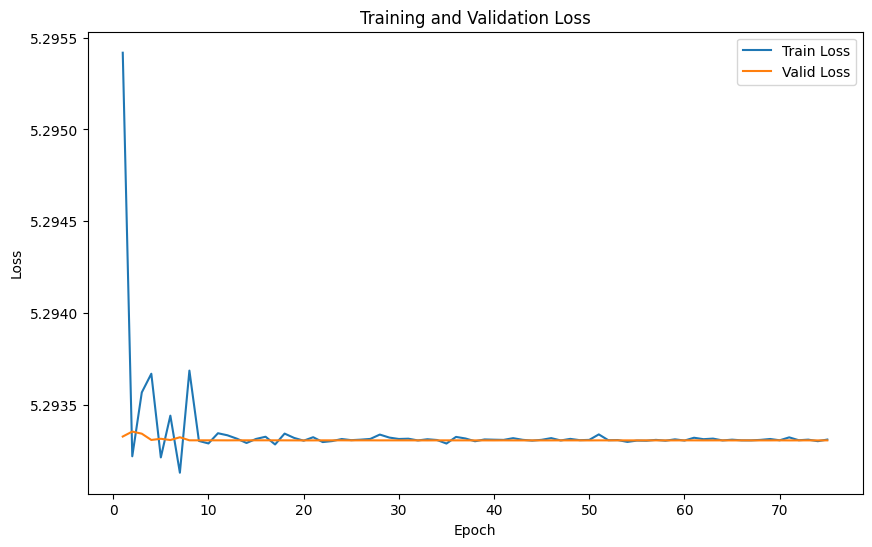

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses)+ 1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Testing

In [37]:
total_correct = 0
correct=0
total_samples = 0
sample=0

with torch.no_grad():
     for audios, labels in test_dataloader:

        audios = audios.to(device)
        labels = labels.to(device)

        audios = audios.permute(0, 2, 1, 3)  # Swap dimensions

        # Reshape to match the expected input shape
        audios = audios.view(8, 800, 15)
        input_lengths = torch.tensor([audios.size(2)] * audios.size(0))

        outputs,_ = model(audios,input_lengths)
        threshold = 0.2
        preds = (outputs > threshold).float()
        preds=preds.cpu()

        for i in range(len(labels)):
          labels=labels.cpu()
          if np.argmax(preds[i] == np.argmax(labels[i])):
             correct = correct + 1
          sample=sample+1

          total_samples=sample

# Calculate test accuracy
test_accuracy = correct / sample

print(f'Total Correct Predictions: {correct}')
print(f'Total Samples: {total_samples}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Total Correct Predictions: 11
Total Samples: 24
Test Accuracy: 45.83%
